In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
0,09/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,07/12/1912,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
2,08/06/1913,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0,The first fatal airplane accident in Canada oc...
3,09/09/1913,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,14.0,0.0,The airship flew into a thunderstorm and encou...
4,10/17/1913,10:30,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30.0,30.0,0.0,Hydrogen gas which was being vented was sucked...


In [26]:
df = pd.read_csv("./Airplane_Crashes_and_Fatalities_Since_1908.csv")
df.head()
# Keep only the 'Summary' column and the target variable
df = df[['Summary', 'Fatalities']]

# Remove duplicates
df = df.drop_duplicates()

# Handle missing values
df = df.dropna(subset=['Summary', 'Fatalities'])

# Data cleaning and standardization
df['Summary'] = df['Summary'].str.lower()  # Convert to lowercase
df['Summary'] = df['Summary'].str.replace(r'[^\w\s]', '')  # Remove punctuation

# Tokenize the text and remove stopwords
stop_words = set(stopwords.words('english'))
stop_words.update(['plane', 'aircraft', 'flight','crashed','en','route','sea','miles','ft','000','500','200','mt'])  # Add additional words to remove
df['Summary'] = df['Summary'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))

# Print the updated DataFrame
print(df.head())

                                             Summary  Fatalities
0  demonstration , u.s. army flyer flown orville ...         1.0
1  first u.s. dirigible akron exploded offshore a...         5.0
2  first fatal airplane accident canada occurred ...         1.0
3  airship flew thunderstorm encountered severe d...        14.0
4  hydrogen gas vented sucked forward engine igni...        30.0


In [87]:
df = pd.read_csv("./Airplane_Crashes_and_Fatalities_Since_1908.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Define the start and end years for the desired ranges
start_year = 1908
end_year = 2008
year_range = 50  # Range of years for each DataFrame

# Create a list to store the DataFrames
df_list = []

end_date_war = pd.to_datetime(f'31/12/1950', format='%d/%m/%Y')
df_prewar = df[(df['Date']<= end_date_war)]
df_postwar = df[(df['Date']> end_date_war)]

# Iterate over the range of years and create DataFrames for each range
for year in range(start_year, end_year, year_range):
    start_date = pd.to_datetime(f'01/01/{year}', format='%d/%m/%Y')
    end_date = pd.to_datetime(f'31/12/{year+year_range-1}', format='%d/%m/%Y')
    filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
    df_list.append(filtered_df)

In [88]:
df = df[['Summary', 'Fatalities']]
df = df.drop_duplicates()
df = df.dropna(subset=['Summary', 'Fatalities'])

    # Data cleaning and standardization
df['Summary'] = df['Summary'].str.lower()  # Convert to lowercase
df['Summary'] = df['Summary'].str.replace(r'[^\w\s]', '')  # Remove punctuation

    # Tokenize the text and remove stopwords
stop_words = set(stopwords.words('english'))
stop_words.update(['plane', 'aircraft', 'flight','crashed','en','route','sea','miles','ft','000','500','200','mt'])  # Add additional words to remove
df['Summary'] = df['Summary'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))

    # Print the updated DataFrame
print(df.head())

                                             Summary  Fatalities
0  demonstration , u.s. army flyer flown orville ...         1.0
1  first u.s. dirigible akron exploded offshore a...         5.0
2  first fatal airplane accident canada occurred ...         1.0
3  airship flew thunderstorm encountered severe d...        14.0
4  hydrogen gas vented sucked forward engine igni...        30.0


In [89]:

    # Fill missing values in the 'Summary' column with an empty string
df['Summary'] = df['Summary'].fillna('')

    # Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

    # Fit and transform the data
features = vectorizer.fit_transform(df['Summary'])

    # Convert the features to a DataFrame
features_df = pd.DataFrame(
    features.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=df.index
)

    # Print the feature matrix
    #print(features_df)

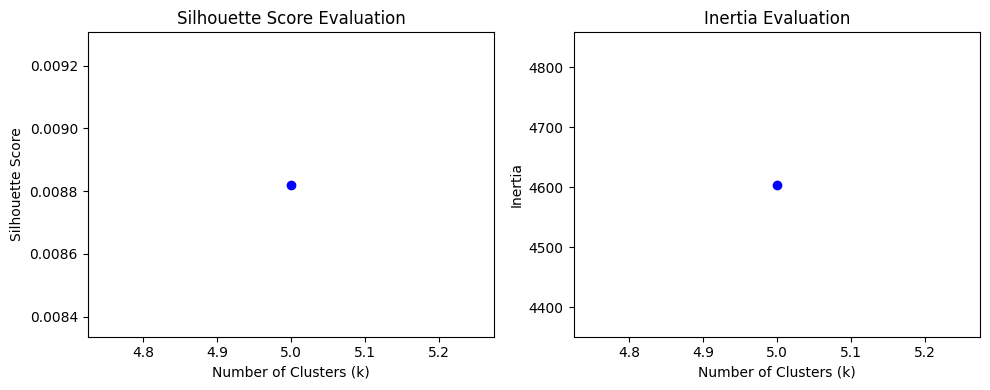

In [90]:
# Define a range of k values to evaluate
k_values = range(5, 6)  # Adjust the range as desired

# Initialize lists to store the evaluation scores
silhouette_scores = []
inertia_scores = []

# Perform clustering and evaluate for each k value
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    labels = kmeans.labels_
    
    # Calculate silhouette score
    silhouette = silhouette_score(features, labels)
    silhouette_scores.append(silhouette)
    
    # Calculate inertia (within-cluster sum of squares)
    inertia_scores.append(kmeans.inertia_)

# Plot the evaluation scores
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(k_values, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Evaluation')

plt.subplot(1, 2, 2)
plt.plot(k_values, inertia_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Inertia Evaluation')

plt.tight_layout()
plt.show()

Label: shot, air, fire, pilot, killed, Count: 2064
Label: approach, pilot, terrain, altitude, ground, Count: 825
Label: engine, failure, landing, fire, emergency, Count: 502
Label: runway, short, approach, landing, overran, Count: 368
Label: taking, shortly, minutes, engine, airport, Count: 227
Label: attempting, land, landing, runway, struck, Count: 215
Label: conditions, weather, vfr, adverse, continued, Count: 178
Label: takeoff, engine, shortly, failure, runway, Count: 153
Label: turbulence, thunderstorm, severe, wing, area, Count: 148
Label: mountain, struck, flew, poor, weather, Count: 146


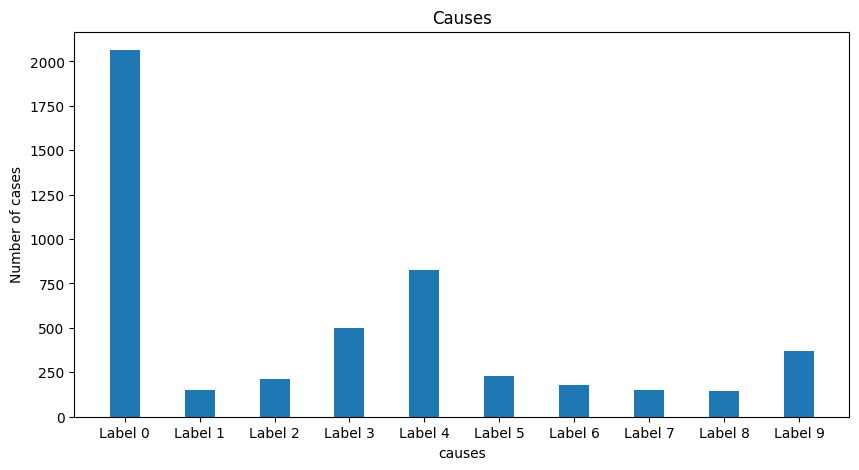

In [91]:
vectorizer = TfidfVectorizer()
stop_words = set(stopwords.words('english'))
stop_words.update(['the','we','cargo','feet','ft','plane', 'aircraft', 'flight','crashed','en','route','sea'])  # Add additional words to remove
stop_words.update(['000','55','miles','ft','000','500','200','mt','rio','de','janeiro'])
df['Summary'] = df['Summary'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))
features = vectorizer.fit_transform(df['Summary'])

# Perform clustering with K-means
k = 10  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(features)

# Get the feature names
terms = vectorizer.get_feature_names_out()

# Analyze cluster characteristics
cluster_keywords = []
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
for i in range(k):
    top_keywords = [terms[ind] for ind in order_centroids[i, :5]]  # Select top 3 words
    cluster_keywords.append(top_keywords)

# Assign labels to clusters based on keywords
cluster_labels = [', '.join(keywords) for keywords in cluster_keywords]

# Add cluster labels to the DataFrame
df['Cluster'] = kmeans.labels_
df['Label'] = [cluster_labels[label] for label in kmeans.labels_]
from collections import Counter
all_labels = [cluster_labels[label] for label in kmeans.labels_]

# Count the occurrences of each label
label_counts = Counter(all_labels)

# Get the labels and their frequencies
labels = [f"Label {i}" for i in range(k)]
labels = [f"Label {i}" for i in range(10)]
frequencies = list(label_counts.values())
    
# Print the most common labels and their frequencies
most_common_labels = label_counts.most_common()
for label, count in most_common_labels:
    print(f"Label: {label}, Count: {count}")

# Count the occurrences of each label
label_counts = Counter(all_labels)
#print("This is the decade ", i)
#plt.figure(figsize=(8, 6))
#plt.pie(frequencies, labels=labels, autopct='%1.1f%%')
#plt.title('Possible causes')
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(labels, frequencies, 
            width = 0.4)
 
plt.xlabel("causes")
plt.ylabel("Number of cases")
plt.title("Causes")
plt.show()

    # Display the chart
    #plt.show()
    #print(df)

In [92]:

##preprocessing for data prewar
dfp = df_prewar[['Summary', 'Fatalities']]
dfp = dfp.drop_duplicates()
dfp = dfp.dropna(subset=['Summary', 'Fatalities'])

    # Data cleaning and standardization
dfp['Summary'] = dfp['Summary'].str.lower()  # Convert to lowercase
dfp['Summary'] = dfp['Summary'].str.replace(r'[^\w\s]', '')  # Remove punctuation

    # Tokenize the text and remove stopwords
stop_words = set(stopwords.words('english'))
stop_words.update(['plane', 'aircraft', 'flight','crashed','en','route','sea','miles','ft','000','500','200','mt'])  # Add additional words to remove
dfp['Summary'] = dfp['Summary'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))

Label: takeoff, disappeared, landing, shot, cargo, Count: 404
Label: pilot, error, weather, approach, related, Count: 100
Label: engine, failure, takeoff, lost, due, Count: 72
Label: attempting, land, struck, landing, trees, Count: 56
Label: fog, mountains, terrain, mountainous, andes, Count: 46
Label: mountain, struck, cargo, flew, ft, Count: 43
Label: poor, weather, conditions, visibility, mountain, Count: 42
Label: mail, storm, snow, taking, fog, Count: 31
Label: fire, caught, anti, aircraft, shot, Count: 27
Label: river, sank, shore, ulua, katherine, Count: 17


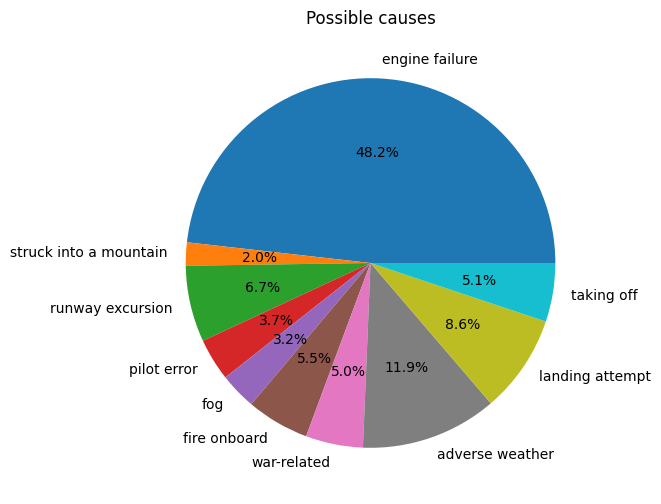

                                                Summary  Fatalities  Cluster  \
0     demonstration , u.s. army flyer flown orville ...         1.0        9   
1     first u.s. dirigible akron exploded offshore a...         5.0        9   
2     first fatal airplane accident canada occurred ...         1.0        9   
3     airship flew thunderstorm encountered severe d...        14.0        3   
4     hydrogen gas vented sucked forward engine igni...        30.0        9   
...                                                 ...         ...      ...   
1098  losing . 1 engine takeoff . engine failure tak...         9.0        6   
1099  mountains shortly taking . pilot error . capta...        31.0        4   
1100  proceeding instruments , . tabayowhile . navig...        38.0        4   
1101  struck trees . okanagan making approach pentic...         2.0        9   
1102            60 north airport taking mar del plata .        17.0        9   

                                       

In [94]:
##Kmeans for data prewar
vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform(dfp['Summary'])

kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(features)

terms = vectorizer.get_feature_names_out()

cluster_keywords = []
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
for i in range(k):
    top_keywords = [terms[ind] for ind in order_centroids[i, :5]]  # Select top 3 words
    cluster_keywords.append(top_keywords)

cluster_labels = [', '.join(keywords) for keywords in cluster_keywords]

dfp['Cluster'] = kmeans.labels_
dfp['Label'] = [cluster_labels[label] for label in kmeans.labels_]
from collections import Counter
all_labels = [cluster_labels[label] for label in kmeans.labels_]

# Count the occurrences of each label
label_counts = Counter(all_labels)

# Print the most common labels and their frequencies
most_common_labels = label_counts.most_common()
for label, count in most_common_labels:
    print(f"Label: {label}, Count: {count}")

# Count the occurrences of each label
label_counts = Counter(all_labels)

# Get the labels and their frequencies
labels = [f"Label {i}" for i in range(k)]
labels = ["engine failure","struck into a mountain", "runway excursion","pilot error","fog","fire onboard","war-related", "adverse weather", "landing attempt","taking off" ]
frequencies = list(label_counts.values())

# Create the pie chart
plt.figure(figsize=(8, 6))
plt.pie(frequencies, labels=labels, autopct='%1.1f%%')
plt.title('Possible causes')

# Display the chart
plt.show()
print(dfp)

Label: shot, air, fire, pilot, killed, Count: 2064
Label: approach, pilot, terrain, altitude, ground, Count: 825
Label: engine, failure, landing, fire, emergency, Count: 502
Label: runway, short, approach, landing, overran, Count: 368
Label: taking, shortly, minutes, engine, airport, Count: 227
Label: attempting, land, landing, runway, struck, Count: 215
Label: conditions, weather, vfr, adverse, continued, Count: 178
Label: takeoff, engine, shortly, failure, runway, Count: 153
Label: turbulence, thunderstorm, severe, wing, area, Count: 148
Label: mountain, struck, flew, poor, weather, Count: 146


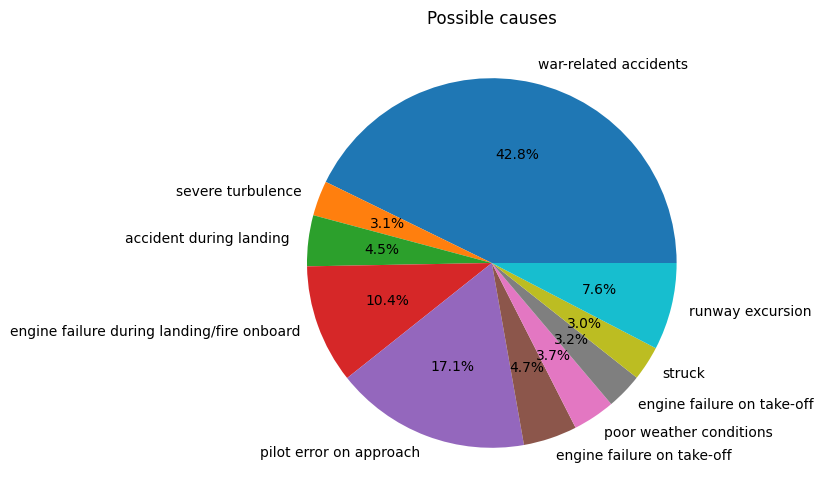

                                                Summary  Fatalities  Cluster  \
0     demonstration , u.s. army flyer flown orville ...         1.0        2   
1     first u.s. dirigible akron exploded offshore a...         5.0        2   
2     first fatal airplane accident canada occurred ...         1.0        2   
3     airship flew thunderstorm encountered severe d...        14.0        3   
4     hydrogen gas vented sucked forward engine igni...        30.0        2   
...                                                 ...         ...      ...   
5263  approach , military transport 4 houses , skidd...        98.0        2   
5264                    approach isiro-matari airport .         4.0        4   
5265  airbus went missing atlantiocean paris , franc...       228.0        2   
5266  air ambulance hills attempting land heavy fog ...         1.0        1   
5267  military transport went missing might due heav...        13.0        2   

                                       

In [95]:
# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

stop_words = set(stopwords.words('english'))
stop_words.update(['cargo','feet','ft','plane', 'aircraft', 'flight','crashed','en','route','sea'])  # Add additional words to remove
stop_words.update(['000','55','miles','ft','000','500','200','mt','rio','de','janeiro'])
df['Summary'] = df['Summary'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))


# Fit and transform the data
features = vectorizer.fit_transform(df['Summary'])

# Perform clustering with K-means
k = 10  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(features)

# Get the feature names
terms = vectorizer.get_feature_names_out()

# Analyze cluster characteristics
cluster_keywords = []
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
for i in range(k):
    top_keywords = [terms[ind] for ind in order_centroids[i, :5]]  # Select top 3 words
    cluster_keywords.append(top_keywords)

# Assign labels to clusters based on keywords
cluster_labels = [', '.join(keywords) for keywords in cluster_keywords]

# Add cluster labels to the DataFrame
df['Cluster'] = kmeans.labels_
df['Label'] = [cluster_labels[label] for label in kmeans.labels_]

# Print the resulting clusters with labels
#print(df)


from collections import Counter

# Print the resulting cluster labels
#for label in kmeans.labels_:
#    print(cluster_labels[label])

# Extract all the labels
all_labels = [cluster_labels[label] for label in kmeans.labels_]

# Count the occurrences of each label
label_counts = Counter(all_labels)

# Print the most common labels and their frequencies
most_common_labels = label_counts.most_common()
for label, count in most_common_labels:
    print(f"Label: {label}, Count: {count}")

# Count the occurrences of each label
label_counts = Counter(all_labels)

# Get the labels and their frequencies
labels = [f"Label {i}" for i in range(k)]
labels = ["war-related accidents","severe turbulence", "accident during landing","engine failure during landing/fire onboard","pilot error on approach","engine failure on take-off","poor weather conditions", "engine failure on take-off", "struck","runway excursion" ]
frequencies = list(label_counts.values())

# Create the pie chart
plt.figure(figsize=(8, 6))
plt.pie(frequencies, labels=labels, autopct='%1.1f%%')
plt.title('Possible causes')

# Display the chart
plt.show()
print(df)
# Concatenate all the labels into a single string
#label_text = ' '.join(all_labels)

# Tokenize the label text
#tokens = label_text.split()

# Count the occurrences of each word
#word_counts = Counter(tokens)

# Print the most common words and their frequencies
#most_common_words = word_counts.most_common()
#for word, count in most_common_words:
#    print(f"Word: {word}, Count: {count}")

Text(0.5, 1.0, 'Possible causes')

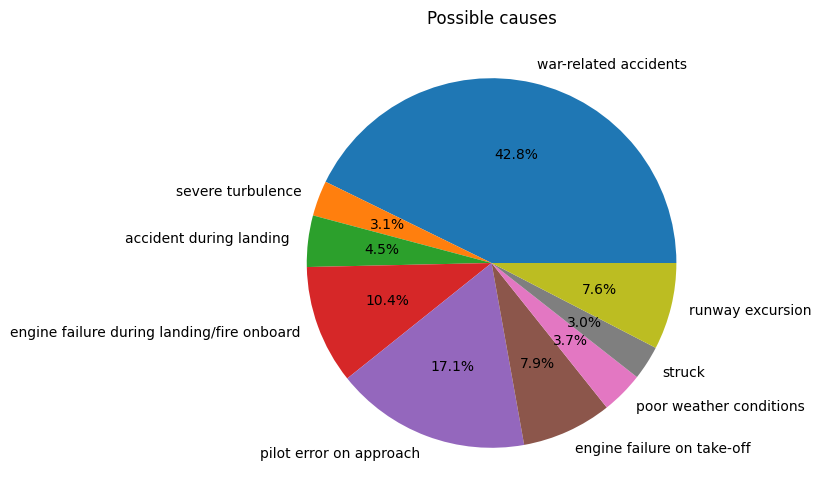

In [24]:
labels2 = ["war-related accidents","severe turbulence", "accident during landing","engine failure during landing/fire onboard","pilot error on approach","engine failure on take-off","poor weather conditions", "struck","runway excursion" ]

frequencies2 = [42.8,3.1,4.5,10.4,17.1,7.9,3.7,3.0,7.6]

# Create the pie chart
plt.figure(figsize=(8, 6))
plt.pie(frequencies2, labels=labels2, autopct='%1.1f%%')
plt.title('Possible causes')

Number of topics:  10
LDA Coherence Score: 0.42037011840642524
NMF Coherence Score: 0.5158711446612723
Number of topics:  11
LDA Coherence Score: 0.3959860385680392
NMF Coherence Score: 0.5029470913287994
Number of topics:  12
LDA Coherence Score: 0.3949636295374431
NMF Coherence Score: 0.5037825229531235
Number of topics:  13
LDA Coherence Score: 0.4002575804630349
NMF Coherence Score: 0.4792906122109659
Number of topics:  14
LDA Coherence Score: 0.4156621486755486
NMF Coherence Score: 0.48077860342194156
Number of topics:  15
LDA Coherence Score: 0.4050385538033768
NMF Coherence Score: 0.48957155027556615
Number of topics:  16
LDA Coherence Score: 0.4085298515776845
NMF Coherence Score: 0.47133791020369065
Number of topics:  17
LDA Coherence Score: 0.4107056632385664
NMF Coherence Score: 0.4631298887702745
Number of topics:  18
LDA Coherence Score: 0.40322670208980105
NMF Coherence Score: 0.4692007580840412
Number of topics:  19
LDA Coherence Score: 0.4097245267270756
NMF Coherence S

/Users/zlatastefanovic/myenv/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Number of topics:  33
LDA Coherence Score: 0.40249875217092546
NMF Coherence Score: 0.424135808508516
Number of topics:  34
LDA Coherence Score: 0.40754983285013047
NMF Coherence Score: 0.43110045166124583
Number of topics:  35
LDA Coherence Score: 0.4056711215057896
NMF Coherence Score: 0.4399614397097891
Number of topics:  36
LDA Coherence Score: 0.4089346101238214
NMF Coherence Score: 0.4268526779507993
Number of topics:  37
LDA Coherence Score: 0.39307404557647313
NMF Coherence Score: 0.42069511281734095
Number of topics:  38
LDA Coherence Score: 0.4019009898011819
NMF Coherence Score: 0.4103540316704047
Number of topics:  39
LDA Coherence Score: 0.40689355837189906
NMF Coherence Score: 0.4386112453115663
Number of topics:  40
LDA Coherence Score: 0.38212820817882287
NMF Coherence Score: 0.4306793944914011
Number of topics:  41
LDA Coherence Score: 0.38373071303301026
NMF Coherence Score: 0.43216304493964325
Number of topics:  42
LDA Coherence Score: 0.41879808946083974
NMF Coheren

/Users/zlatastefanovic/myenv/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Number of topics:  94
LDA Coherence Score: 0.3450264657593319
NMF Coherence Score: 0.40377937788890006
Number of topics:  95
LDA Coherence Score: 0.35863823092545977
NMF Coherence Score: 0.39754195083595795
Number of topics:  96
LDA Coherence Score: 0.35415143317465186
NMF Coherence Score: 0.3754372048853165
Number of topics:  97
LDA Coherence Score: 0.355679249421441
NMF Coherence Score: 0.38336691540448714
Number of topics:  98
LDA Coherence Score: 0.35030076340649147
NMF Coherence Score: 0.3829682123308751
Number of topics:  99
LDA Coherence Score: 0.36032323107937403
NMF Coherence Score: 0.3905455472884964


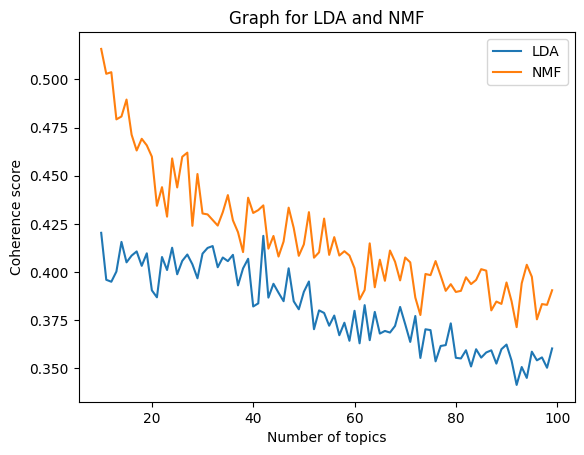

In [6]:
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from gensim.models import CoherenceModel
from gensim import corpora
from gensim.models import LdaModel, Nmf


# Extract the text data (summaries)
summaries = df['Summary']

lda_coherence_scores = []
nmf_coherence_scores = []
# Initialize the TF-IDF vectorizer
additional_words = ['plane', 'aircraft', 'flight','crashed','en','route','sea','miles','ft','000','500','200','mt','cargo','later','bogota','afghan']  # Add additional words to remove

all_stop_words = list(ENGLISH_STOP_WORDS)+additional_words
vectorizer = TfidfVectorizer(stop_words=all_stop_words)

# Fit and transform the text data
tfidf_matrix = vectorizer.fit_transform(summaries)
n = 100
# Define the number of topics
for num_topics in range(10,n):

    # Perform LDA
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(tfidf_matrix)

    # Perform NMF
    nmf = NMF(n_components=num_topics, random_state=42)
    nmf.fit(tfidf_matrix)

    # Get the top words for each topic
    def get_top_words(model, feature_names, n_top_words):
        top_words = []
        for topic_idx, topic in enumerate(model.components_):
            topic_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
            top_words.append(topic_words)
        return top_words

    # Get the feature names from the TF-IDF vectorizer
    feature_names = vectorizer.get_feature_names_out()

    # Get the top words for each topic in LDA
    lda_top_words = get_top_words(lda, feature_names, n_top_words=5)

    # Get the top words for each topic in NMF
    nmf_top_words = get_top_words(nmf, feature_names, n_top_words=5)
    print("Number of topics: ",num_topics)
    # Print the top words for each topic
    #for topic_idx in range(num_topics):
        #print(f"Topic {topic_idx + 1} (LDA):", ", ".join(lda_top_words[topic_idx]))
        #print()

    #for topic_idx in range(num_topics):
     #   print(f"Topic {topic_idx + 1} (NMF):", ", ".join(nmf_top_words[topic_idx]))
      #  print()

    # Convert the summaries to a list of tokenized sentences
    tokenized_summaries = [summary.split() for summary in summaries]

    # Create a dictionary from the tokenized summaries
    dictionary = corpora.Dictionary(tokenized_summaries)

    # Create a bag-of-words corpus
    corpus = [dictionary.doc2bow(tokens) for tokens in tokenized_summaries]

    # Calculate topic coherence using c_v metric for LDA
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
    lda_coherence_model = CoherenceModel(model=lda_model, texts=tokenized_summaries, dictionary=dictionary, coherence='c_v')
    lda_coherence = lda_coherence_model.get_coherence()

    # Calculate topic coherence using c_v metric for NMF
    nmf_model = Nmf(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
    nmf_coherence_model = CoherenceModel(model=nmf_model, texts=tokenized_summaries, dictionary=dictionary, coherence='c_v')
    nmf_coherence = nmf_coherence_model.get_coherence()

    # Print the topic coherence scores
    print("LDA Coherence Score:", lda_coherence)
    lda_coherence_scores.append(lda_coherence)
    print("NMF Coherence Score:", nmf_coherence)
    nmf_coherence_scores.append(nmf_coherence)

plt.plot([i for i in range(10,n)], lda_coherence_scores, label='LDA')
plt.plot([i for i in range(10,n)], nmf_coherence_scores, label='NMF')

# Adding labels and title
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')
plt.title('Graph for LDA and NMF')

# Adding a legend
plt.legend()

# Displaying the graph
plt.show()


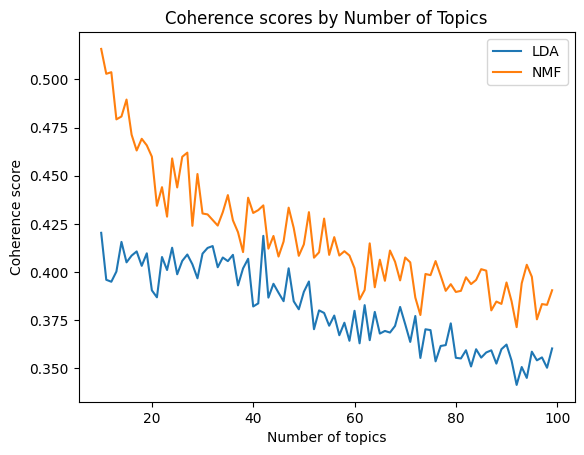

In [8]:
topics = [i for i in range(10,100)]
plt.plot(topics, lda_coherence_scores, label='LDA')
plt.plot(topics, nmf_coherence_scores, label='NMF')
sum = [nmf_coherence_scores[i]+lda_coherence_scores[i] for i in range(0,15)]
#plt.plot(topics,sum, label = 'SUM')

# Adding labels and title
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')
plt.title('Coherence scores by Number of Topics')

# Adding a legend
plt.legend()

# Displaying the graph
plt.show()
##LDA works best for 11 different topics
##NMF works best for 29 different topics

In [129]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from gensim.models import CoherenceModel
from gensim import corpora
from gensim.models import LdaModel, Nmf


# Extract the text data (summaries)
summaries = df['Summary']

lda_coherence_scores = []
nmf_coherence_scores = []
# Initialize the TF-IDF vectorizer
additional_words = ['plane', 'aircraft', 'flight','francisco','mediterranean','crashed','en','route','sea','miles','ft','000','500','200','mt','cargo','later','bogota','afghan']  # Add additional words to remove

all_stop_words = list(ENGLISH_STOP_WORDS)+additional_words
vectorizer = TfidfVectorizer(stop_words=all_stop_words)


num_topics = 29
# Fit and transform the text data
tfidf_matrix = vectorizer.fit_transform(summaries)
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(tfidf_matrix)

# Perform NMF
nmf = NMF(n_components=num_topics, random_state=42)
nmf.fit(tfidf_matrix)

# Get the top words for each topic
def get_top_words(model, feature_names, n_top_words):
    top_words = []
    for topic_idx, topic in enumerate(model.components_):
        topic_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_words.append(topic_words)
    return top_words

# Get the feature names from the TF-IDF vectorizer
feature_names = vectorizer.get_feature_names_out()

# Get the top words for each topic in LDA
lda_top_words = get_top_words(lda, feature_names, n_top_words=5)

    # Get the top words for each topic in NMF
#nmf_top_words = get_top_words(nmf, feature_names, n_top_words=5)
print("Number of topics: ",num_topics)
    #Print the top words for each topic
for topic_idx in range(num_topics):
    print(f"Topic {topic_idx + 1} (LDA):", ", ".join(lda_top_words[topic_idx]))
    print()

#for topic_idx in range(num_topics):
#    print(f"Topic {topic_idx + 1} (NMF):", ", ".join(nmf_top_words[topic_idx]))
#    print()

    # Convert the summaries to a list of tokenized sentences
tokenized_summaries = [summary.split() for summary in summaries]

    # Create a dictionary from the tokenized summaries
dictionary = corpora.Dictionary(tokenized_summaries)
# Convert the summaries to a list of tokenized sentences
tokenized_summaries = [summary.split() for summary in summaries]

    # Create a dictionary from the tokenized summaries
dictionary = corpora.Dictionary(tokenized_summaries)

    # Create a bag-of-words corpus
corpus = [dictionary.doc2bow(tokens) for tokens in tokenized_summaries]

    # Calculate topic coherence using c_v metric for LDA
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
lda_coherence_model = CoherenceModel(model=lda_model, texts=tokenized_summaries, dictionary=dictionary, coherence='c_v')
lda_coherence = lda_coherence_model.get_coherence()

    # Calculate topic coherence using c_v metric for NMF
#nmf_model = Nmf(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
#nmf_coherence_model = CoherenceModel(model=nmf_model, texts=tokenized_summaries, dictionary=dictionary, coherence='c_v')
#nmf_coherence = nmf_coherence_model.get_coherence()

    # Print the topic coherence scores
print("LDA Coherence Score:", lda_coherence)
#print("NMF Coherence Score:", nmf_coherence)


Number of topics:  29
Topic 1 (LDA): disappeared, cause, undetermined, unknown, reasons

Topic 2 (LDA): attempting, land, short, runway, stalled

Topic 3 (LDA): separated, touch, landings, practicing, spiraled

Topic 4 (LDA): fuselage, crack, inflight, separation, wing

Topic 5 (LDA): shortly, taking, experiencing, engine, disorientation

Topic 6 (LDA): storm, premature, rainstorm, mda, undershot

Topic 7 (LDA): caught, mechanical, downdrafts, beach, blown

Topic 8 (LDA): fuel, ran, evasive, flamed, aboard

Topic 9 (LDA): typhoon, impairment, 30, minutes, rugged

Topic 10 (LDA): shot, air, rebels, missile, surface

Topic 11 (LDA): takeoff, shifted, limits, mail, hour

Topic 12 (LDA): approach, midair, aboard, exploded, collision

Topic 13 (LDA): cabin, passenger, detonation, device, warning

Topic 14 (LDA): mountain, weather, conditions, poor, flew

Topic 15 (LDA): engine, landing, failure, takeoff, lost

Topic 16 (LDA): hillside, running, pattern, holding, fuel

Topic 17 (LDA): disapp

In [128]:
nmf_coherence_scores = []
additional_words = ['plane', 'aircraft', 'flight','crashed','en','route','sea','miles','ft','000','500','200','mt','cargo','later','bogota','afghan']  # Add additional words to remove

all_stop_words = list(ENGLISH_STOP_WORDS)+additional_words
vectorizer = TfidfVectorizer(stop_words=all_stop_words)


num_topics = 11
# Fit and transform the text data
tfidf_matrix = vectorizer.fit_transform(summaries)
# Perform NMF
nmf = NMF(n_components=num_topics, random_state=42)
nmf.fit(tfidf_matrix)

# Get the top words for each topic
def get_top_words(model, feature_names, n_top_words):
    top_words = []
    for topic_idx, topic in enumerate(model.components_):
        topic_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_words.append(topic_words)
    return top_words

# Get the feature names from the TF-IDF vectorizer
feature_names = vectorizer.get_feature_names_out()

# Get the top words for each topic in NMF
nmf_top_words = get_top_words(nmf, feature_names, n_top_words=5)

print("Number of topics: ",num_topics)
    #Print the top words for each topic
for topic_idx in range(num_topics):
    print(f"Topic {topic_idx + 1} (NMF):", ", ".join(nmf_top_words[topic_idx]))
    print()

    # Convert the summaries to a list of tokenized sentences
tokenized_summaries = [summary.split() for summary in summaries]

    # Create a dictionary from the tokenized summaries
dictionary = corpora.Dictionary(tokenized_summaries)
# Convert the summaries to a list of tokenized sentences
tokenized_summaries = [summary.split() for summary in summaries]

    # Create a dictionary from the tokenized summaries
dictionary = corpora.Dictionary(tokenized_summaries)

    # Create a bag-of-words corpus
corpus = [dictionary.doc2bow(tokens) for tokens in tokenized_summaries]
  # Calculate topic coherence using c_v metric for NMF
nmf_model = Nmf(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
nmf_coherence_model = CoherenceModel(model=nmf_model, texts=tokenized_summaries, dictionary=dictionary, coherence='c_v')
nmf_coherence = nmf_coherence_model.get_coherence()

# Print the topic coherence scores
print("NMF Coherence Score:", nmf_coherence)


Number of topics:  11
Topic 1 (NMF): engine, failure, lost, experiencing, right

Topic 2 (NMF): mountain, flew, struck, fog, hit

Topic 3 (NMF): takeoff, shortly, aborted, stalled, overloaded

Topic 4 (NMF): conditions, vfr, adverse, weather, continued

Topic 5 (NMF): approach, final, crew, pilot, descent

Topic 6 (NMF): attempting, land, fog, burned, airport

Topic 7 (NMF): taking, shortly, minutes, airport, lost

Topic 8 (NMF): runway, short, overran, fog, hit

Topic 9 (NMF): poor, weather, conditions, visibility, conditons

Topic 10 (NMF): landing, emergency, attempt, make, gear

Topic 11 (NMF): struck, ground, high, trees, wing

NMF Coherence Score: 0.507661761223286


In [108]:
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations
import numpy as np

# Calculate topic coherence using c_v metric
def calculate_topic_coherence(top_words):
    coherence_scores = []
    for word_list in top_words:
        pairs = list(combinations(word_list, 2))
        pairwise_similarity = []
        for pair in pairs:
            # Calculate cosine similarity between word vectors
            pair_similarity = cosine_similarity(tfidf_matrix[:, vectorizer.vocabulary_[pair[0]]],
                                                tfidf_matrix[:, vectorizer.vocabulary_[pair[1]]])
            pairwise_similarity.append(pair_similarity[0][0])
        coherence_score = np.mean(pairwise_similarity)
        coherence_scores.append(coherence_score)
    return coherence_scores

# Calculate coherence scores for LDA
lda_coherence_scores = calculate_topic_coherence(lda_top_words)

# Calculate coherence scores for NMF
nmf_coherence_scores = calculate_topic_coherence(nmf_top_words)

# Print the coherence scores for each topic in LDA
for topic_idx, coherence_score in enumerate(lda_coherence_scores):
    print(f"Topic {topic_idx + 1} (LDA) coherence score:", coherence_score)
    print()

# Print the coherence scores for each topic in NMF
for topic_idx, coherence_score in enumerate(nmf_coherence_scores):
    print(f"Topic {topic_idx + 1} (NMF) coherence score:", coherence_score)
    print()

Topic 1 (LDA) coherence score: 0.0

Topic 2 (LDA) coherence score: 0.0

Topic 3 (LDA) coherence score: 0.0

Topic 4 (LDA) coherence score: 0.0

Topic 5 (LDA) coherence score: 0.0

Topic 1 (NMF) coherence score: 0.0

Topic 2 (NMF) coherence score: 0.0

Topic 3 (NMF) coherence score: 0.0

Topic 4 (NMF) coherence score: 0.0

Topic 5 (NMF) coherence score: 0.0

